In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from collections import deque
import random

# Define the StockTradingEnv class
class StockTradingEnv:
    def __init__(self, data, model, scaler):
        self.data = data
        self.model = model
        self.scaler = scaler
        self.index = 0
        self.done = False
        self.total_reward = 0
        self.initial_balance = 10000.0
        self.balance = self.initial_balance

    def reset(self):
        self.index = 0
        self.done = False
        self.total_reward = 0
        self.balance = self.initial_balance
        state = self.data.iloc[self.index].values
        prediction = self.predict_next_close(self.index)
        extended_state = np.append(state, prediction)
        return extended_state

    def predict_next_close(self, index):
        if 'Close' not in self.data.columns:
            # Close column is not available for this stock, return a default value
            return 0.0

        last_sequence = self.data['Close'].iloc[index-5:index].values
        if len(last_sequence) < 5:
            # Not enough data for prediction, return a default value
            return 0.0

        last_sequence_scaled = self.scaler.transform(last_sequence.reshape(-1, 1))
        last_sequence_reshaped = np.reshape(last_sequence_scaled, (1, 5, 1))
        predicted_scaled = self.model.predict(last_sequence_reshaped)
        predicted = self.scaler.inverse_transform(predicted_scaled)[0, 0]
        return predicted



    def step(self, action):
      # 0->Hold, 1->Buy, 2->Sell
      current_row = self.data.iloc[self.index]
      next_row = self.data.iloc[self.index + 1]
      reward = 0
      if action == 1:  # Buy
          reward = (next_row['Close'] - current_row['Open'])
      elif action == 2:  # Sell
          reward = (current_row['Open'] - next_row['Close'])

      self.total_reward += reward
      self.index += 1

      if self.index >= len(self.data) - 1:
          self.done = True
          self.index = 0  # Reset the index to start a new episode

      next_state = self.data.iloc[self.index + 1].values
      prediction = self.predict_next_close(self.index + 1)
      extended_next_state = np.append(next_state, prediction)
      return extended_next_state, reward, self.done, {}




# Define the DQNAgent class
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.action_size)
        )
        self.optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        state_tensor = torch.FloatTensor(state).float()
        act_values = self.model(state_tensor)
        return torch.argmax(act_values).item()

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        criterion = nn.MSELoss()
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state).float()
            next_state_tensor = torch.FloatTensor(next_state).float()

            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state_tensor)).item()
            else:
                target = reward
            target_tensor = torch.tensor([target], dtype=torch.float32)

            current_value = self.model(state_tensor).squeeze()[action].unsqueeze(0)
            loss = criterion(current_value, target_tensor)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.model.state_dict(), name)


# Fetch Dow Jones 30 stocks and preprocess data
# (Insert your data fetching and preprocessing code here)
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Fetch Dow Jones 30 stocks
tickers = ["AAPL", "AXP", "BA", "CAT", "CSCO", "CVX", "DIS"]  # Add all 30 here

def fetch_data(tickers):
    data = {}
    for ticker in tickers:
        stock_data = yf.download(ticker, start="2021-01-01", end="2023-10-01", progress=False)
        stock_data['Return'] = stock_data['Close'].pct_change()
        data[ticker] = stock_data.dropna()
    return data

data = fetch_data(tickers)

# Sort by performance and pick the top 5
sorted_tickers = sorted(tickers, key=lambda x: data[x]['Return'].sum(), reverse=True)[:5]
print("Top 5 performing stocks:", sorted_tickers)

# ... (previous code) ...

# LSTM Model for the top-performing stock (can loop for others)
ticker = sorted_tickers[0]
df = data[ticker].copy()
df.dropna(inplace=True)  # Drop rows with missing data

# Check if the DataFrame is empty after dropping rows with missing data
if df.empty:
    raise ValueError("DataFrame is empty after dropping rows with missing data.")

# Scaling and reshaping for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']].values)

X, y = [], []
for i in range(5, len(scaled_data)):
    X.append(scaled_data[i-5:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Predictions
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(np.array(predicted).reshape(-1, 1))
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

df['Predicted'] = np.nan
df.iloc[-len(predicted):, df.columns.get_loc('Predicted')] = predicted

# Trading Strategy
test = df[-len(predicted):].copy()
test['Position'] = np.where(test['Predicted'] > test['Open'], 1, -1)

# Calculate 5-day percentage change for test data
test['5_Day_Pct_Change'] = test['Close'].pct_change(periods=5)

# Portfolio variables
initial_balance = 10000.00
balance = initial_balance

# Track cumulative returns
cumulative_returns = []

# Trading logic for each test day
for idx, row in test.iterrows():
    predicted_close = row['Predicted']
    actual_close = row['Close']
    open_price = row['Open']
    five_day_pct_change = row['5_Day_Pct_Change']

    if predicted_close > open_price and five_day_pct_change > 0:
        if actual_close > open_price:
            balance += (actual_close - open_price) * (balance / open_price)
        else:
            balance -= (open_price - actual_close) * (balance / open_price)
    elif predicted_close < open_price and five_day_pct_change < 0:
        if actual_close < open_price:
            balance += (open_price - actual_close) * (balance / open_price)
        else:
            balance -= (actual_close - open_price) * (balance / open_price)

    cumulative_returns.append(balance)

# Create the StockTradingEnv instance
env = StockTradingEnv(df, model, scaler)
state_size = len(env.reset())
action_size = 3  # Change this based on your action space

# Create the DQNAgent instance
agent = DQNAgent(state_size, action_size)

# Training loop
EPISODES = 20
results = []

for e in range(EPISODES):
    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"episode: {e+1}/{EPISODES}, reward: {env.total_reward}, epsilon: {agent.epsilon:.2}")
            results.append({
                "Episode": e+1,
                "Reward": env.total_reward,
                "Epsilon": agent.epsilon
            })
    if len(agent.memory) > 32:
        agent.replay(32)

# Convert the results to a pandas DataFrame and save to Excel
results_df = pd.DataFrame(results)
results_df.to_excel("agent_results_v2.xlsx", index=False)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 43ms/step
episode: 13/20, reward: -11.320205688476562, epsilon: 0.94
1/1 [==============================] - 0s 41ms/step
episode: 14/20, reward: 71.36994171142578, epsilon: 0.94
1/1 [==============================] - 0s 33ms/step
episode: 15/20, reward: -43.58997344970703, epsilon: 0.93
1/1 [==============================] - 0s 32ms/step
episode: 16/20, reward: 32.680145263671875, epsilon: 0.93
1/1 [==============================] - 0s 38ms/step
episode: 17/20, reward: 88.13004302978516, epsilon: 0.92
1/1 [==============================] - 0s 32ms/step
episode: 18/20, reward: 58.12007141113281, epsilon: 0.92
1/1 [==============================] - 0s 36ms/step
episode: 19/20, reward: 79.31009674072266, epsilon: 0.91
1/1 [==============================] - 0s 32ms/step
episode: 20/20, reward: -29.189956665039062, epsilon: 0.91


The provided code presents an integration of Deep Q-Learning (DQL) with a Long Short-Term Memory (LSTM) model for stock trading. Below is an explanation of how the DRL agent learns based on the LSTM rules for Buy, Sell, and Hold, and how the stocks are selected for use:
Selection of Stocks

    Fetching Data: The code fetches historical stock prices for the list of tickers defined in the tickers list using the yfinance library.

    Ranking Stocks: Once the data for all the tickers is fetched, the stocks are sorted based on their performance (calculated as the sum of their returns). The top 5 performing stocks are then selected.

LSTM Model for Stock Prediction

    Data Preparation: The code prepares the data by scaling the 'Close' prices and creating sequences of 5 days for training the LSTM model. These sequences act as input features, and the next day's 'Close' price acts as the label.

    Model Architecture: The LSTM model consists of two LSTM layers followed by a Dense layer. This model is trained to predict the next day's closing price based on the past 5 days.

    Training: The LSTM model is trained using the prepared data and the Adam optimizer. The trained model predicts the next day's 'Close' price.

    Strategy Using LSTM Prediction: A trading strategy is then defined using the LSTM predictions. If the predicted close price for the next day is higher than the current day's open price, a "buy" action is suggested; otherwise, a "sell" action is suggested.

DRL Agent for Stock Trading

    Environment: A custom trading environment, StockTradingEnv, is created where the agent interacts and learns. This environment provides the following:
        State: Current stock data concatenated with the LSTM prediction for the next close price.
        Actions: Buy, Sell, or Hold.
        Reward: Calculated based on the change in stock prices resulting from the action taken.

    Agent: The DQL agent (DQNAgent) consists of a neural network model (_build_model) that predicts Q-values for each action based on the state. It uses the concept of exploration vs. exploitation determined by epsilon. If a random number is less than epsilon, the agent takes a random action (exploration); otherwise, it takes the action with the highest Q-value (exploitation).

    Learning: The agent learns by:
        Storing experiences in memory (state, action, reward, next state, done) using the remember method.
        Sampling from this memory and updating the Q-values using the Bellman equation in the replay method. The Q-value for the taken action is updated towards the reward plus the discounted maximum Q-value of the next state. This update helps the agent to learn the optimal action-value function.

    Training Loop: During the training loop, the agent interacts with the environment, selects actions, receives rewards, and learns from the experiences. After each episode, the agent's results (total reward and epsilon) are printed, and after a certain number of experiences, the agent learns from its memory.

Conclusion

The agent is essentially being trained to optimize its actions (Buy, Sell, Hold) in the stock trading environment using the Q-learning algorithm. It uses both its current understanding (Q-values) and the predictions from the LSTM model to decide on actions. Over time, the agent's exploration rate (epsilon) decays, allowing it to rely more on its learned knowledge and less on random actions.

By combining LSTM (which is good for sequential data) with DQL (which can optimize decisions over time), this approach tries to create a more informed and adaptive trading agent. The stocks used in this process are the top-performing ones based on their historical returns.

Here's a breakdown of what's happening:

    A list of tickers (in this case, a subset of the Dow Jones 30) is defined.
    The fetch_data function is defined to fetch stock data for each ticker in the provided list and calculate the daily returns. This function stores each ticker's data in a dictionary where the key is the ticker name and the value is the respective stock's DataFrame.
    The fetch_data function is then called with the list of tickers to retrieve the data.
    The tickers are then sorted based on the sum of their returns using the line sorted(tickers, key=lambda x: data[x]['Return'].sum(), reverse=True)[:5]. The sorting is in descending order (i.e., stocks with the highest returns are at the beginning of the list) and only the top 5 are selected using the slice [:5].
    The top 5 performing stocks are printed to the console.

This stage happens after defining the DRL agent and environment classes but before the LSTM model building and DRL agent training stages.
User
Is the DRL interacting with the stock selection at all?
ChatGPT

No, the Deep Reinforcement Learning (DRL) agent in the provided code does not directly interact with the stock selection process. The stock selection (ranking and choosing the top-performing stocks) is determined by historical returns before the DRL agent is even instantiated or trained.

Here's a quick breakdown:

    Stock Selection:
        The stocks are fetched.
        Their returns are computed.
        The stocks are ranked based on the sum of their returns.
        The top 5 performing stocks are selected.

    LSTM Prediction:
        The LSTM model is built and trained on the top-performing stock (as per ticker = sorted_tickers[0]). This model predicts stock closing prices.

    DRL Interaction:
        The DRL agent interacts with the StockTradingEnv environment.
        The environment uses the LSTM's predictions to compute the next state in the predict_next_close function.
        The DRL agent decides on actions (buy, sell, hold) based on these states and learns from the rewards it receives during interaction with the environment.

The DRL agent's role is to learn an optimal trading strategy based on the LSTM predictions and historical stock data. The selection of which stock to use (in this case, the top-performing stock) is made prior to and independently of the DRL agent's interactions.
User
so what is the DRL doing to improve the model?
ChatGPT

The Deep Reinforcement Learning (DRL) in the provided code is responsible for learning an optimal trading strategy based on the LSTM's predictions and the actual stock price data. Specifically, the DRL agent is trying to maximize the rewards it receives from trading actions (buy, sell, hold) in the StockTradingEnv environment.

Here's how the DRL contributes to improving the trading strategy:

    Action Selection: The DRL agent chooses an action (buy, sell, hold) based on the current state, which includes the stock's current data and the predicted next closing price by the LSTM. Initially, the agent's actions are primarily random due to high exploration (epsilon is set to 1.0). Over time, as the agent learns, it relies more on its learned policy (Q-values) and less on random actions.

    Reward Processing: The environment returns a reward for each action taken by the agent:
        A positive reward when the agent correctly predicts the movement and profits from it.
        A negative reward when the agent's action leads to a loss.

    Memory Storage: The agent stores each interaction (state, action, reward, next_state, done) in its memory (replay buffer). This stored experience will be used to update the agent's understanding of the environment and improve its policy.

    Experience Replay: At regular intervals, the agent samples experiences from its memory to update its policy. This allows the agent to learn from both recent and older experiences, stabilizing the learning process.

    Policy Update: The agent updates its Q-values (a representation of expected rewards) using the sampled experiences. The goal is to adjust the policy in a direction that increases expected cumulative rewards. The agent uses the Mean Squared Error (MSE) loss between its current Q-value estimate and the updated Q-value target to adjust its policy.

    Epsilon Decay: Over time, the agent reduces its exploration rate (epsilon). This means the agent relies more on its learned policy and less on random actions as it becomes more confident in its understanding of the environment.

The overall idea is that, by interacting with the StockTradingEnv environment and continually updating its policy based on received rewards and stored experiences, the DRL agent learns an effective trading strategy that capitalizes on the predictions provided by the LSTM model. The agent aims to maximize its cumulative rewards, which translates to maximizing profits from trading the stock.

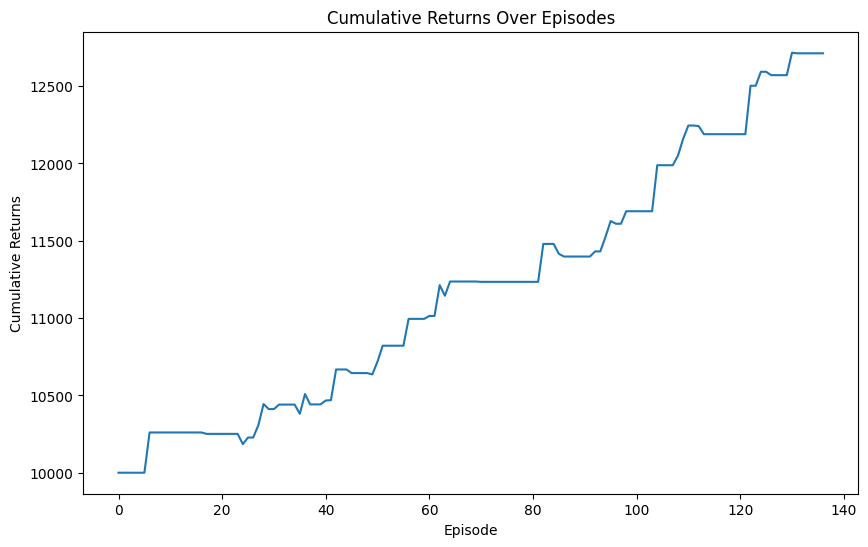

In [31]:
import matplotlib.pyplot as plt

# After training loop
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns)
plt.xlabel("Episode")
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns Over Episodes")
plt.show()


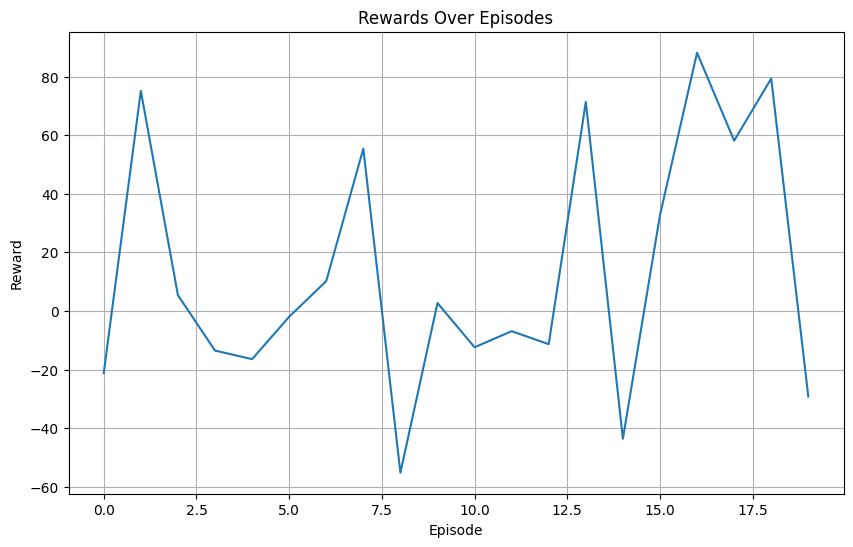

In [20]:
import matplotlib.pyplot as plt

# Assuming you have your results_df DataFrame with the "Reward" column
rewards = results_df["Reward"]

# Plot the rewards over episodes
plt.figure(figsize=(10, 6))
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Rewards Over Episodes")
plt.grid(True)
plt.show()



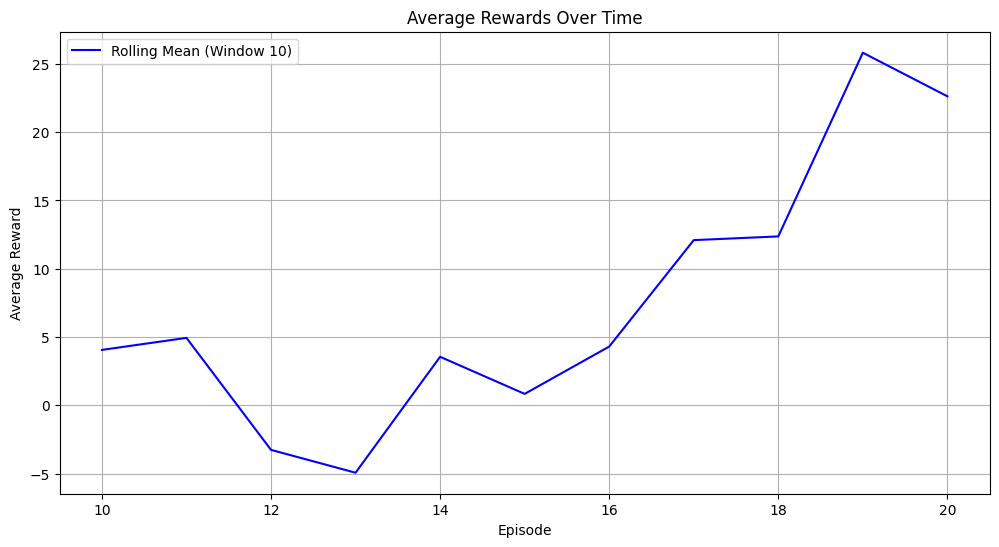

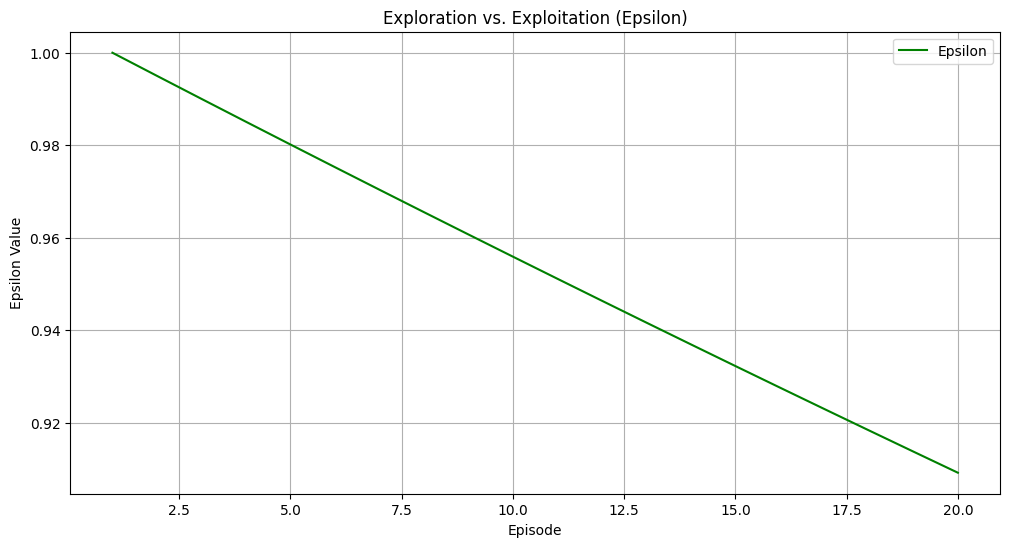

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the results DataFrame (assuming you have collected data)
# results_df = pd.read_excel("agent_results_v2.xlsx")

# 1. Average Rewards Over Time (Rolling Mean)
window = 10  # Rolling mean window size
rolling_rewards = results_df['Reward'].rolling(window=window).mean()

plt.figure(figsize=(12, 6))
plt.plot(results_df['Episode'], rolling_rewards, label=f'Rolling Mean (Window {window})', color='blue')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Rewards Over Time')
plt.legend()
plt.grid()
plt.show()

# 2. Exploration vs. Exploitation (Epsilon)
plt.figure(figsize=(12, 6))
plt.plot(results_df['Episode'], results_df['Epsilon'], label='Epsilon', color='green')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Exploration vs. Exploitation (Epsilon)')
plt.legend()
plt.grid()
plt.show()



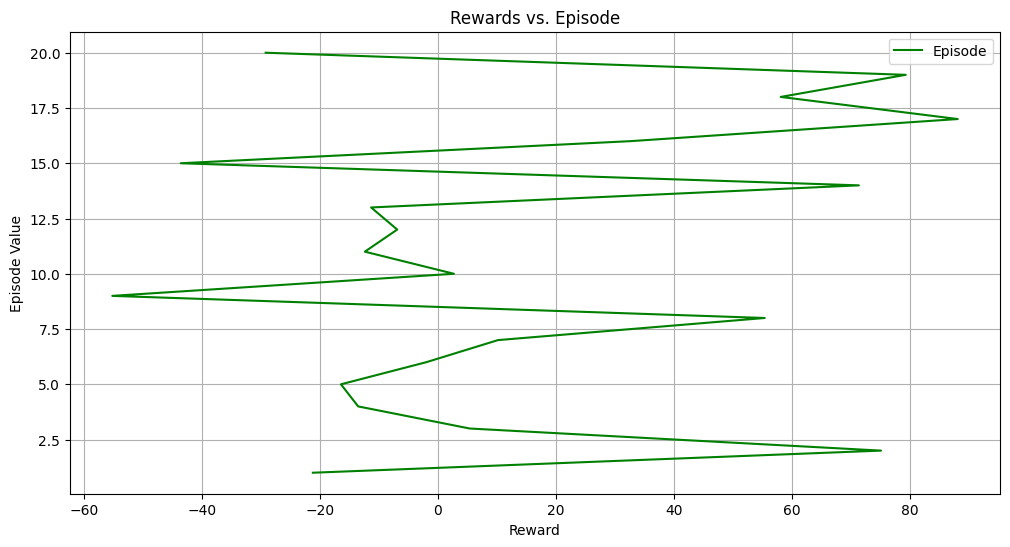

In [30]:

# 2. Exploration vs. Exploitation (Epsilon)
plt.figure(figsize=(12, 6))
plt.plot(results_df['Reward'], results_df['Episode'], label='Episode', color='green')
plt.xlabel('Reward')
plt.ylabel('Episode Value')
plt.title('Rewards vs. Episode')
plt.legend()
plt.grid()
plt.show()


how can it be used in unseen data?
ChatGPT

To use the trained DRL agent on unseen data, you would follow these general steps:

    Prepare the Unseen Data: This involves fetching the new, unseen stock data, preprocessing it, and scaling it using the same scaler that was used for the training data. Note that only the transformation method of the scaler should be used, not the fitting method, since you want to ensure consistency with the previous scaling.

    Predict with LSTM: Use the trained LSTM model to make predictions on the unseen data. The LSTM's role is to provide a forecasted closing price for the next day, which will be part of the state fed into the DRL agent.

    Initialize the Environment: Create an instance of the StockTradingEnv environment using the unseen data and the LSTM model.

    Deploy the DRL Agent: Run the DRL agent in a manner similar to the training loop, but without the learning phases (i.e., no experience storage or replay). Essentially, the agent will traverse through the unseen data and make decisions (buy, sell, or hold) based on its learned policy and the predicted values from the LSTM.

    python

    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)  # The agent selects an action based on its learned policy
        next_state, reward, done, _ = env.step(action)
        state = next_state
        # Store or log the action, reward, and other relevant information

    Evaluate Performance: After running the agent on the unseen data, evaluate its performance by calculating metrics such as total profit, the number of profitable trades, maximum drawdown, etc. This will give you insights into how well the agent and LSTM model generalize to new data.

    Re-training (if necessary): If the agent's performance on the unseen data is not satisfactory, or if you have accumulated a significant amount of new data, consider re-training the agent and/or LSTM model to better adapt to the new conditions.

Remember, financial markets are non-stationary, meaning their behaviors can change over time due to various factors (e.g., economic conditions, global events). Thus, even a well-trained agent may require periodic re-training or fine-tuning when exposed to new data or changing market conditions. Always evaluate the performance of the model in a controlled environment before deploying it in a real-world setting.

so the agent's learning experience is saved in memory and it will be ready to use what it has learned?
ChatGPT

Yes, exactly!

The agent's learning experience is stored in its memory (a deque named memory in the given code). The memory keeps track of recent experiences (state, action, reward, next_state, done) as the agent interacts with the environment. This is a core concept in Deep Q-Learning called the experience replay.

During training, after each episode (or at regular intervals), the agent samples a batch of experiences from this memory to learn from past actions. It uses these experiences to update its neural network (the Q-network) to better estimate the Q-values for state-action pairs. The Q-values guide the agent's decisions on which actions to take in given states.

Once the agent has been trained, even though the experience replay memory has played its part in updating the Q-network, the real "knowledge" or "intelligence" of the agent is encoded in the weights of the Q-network. Therefore, for deployment on unseen data or in real-world scenarios, you only need the trained weights of the Q-network.

If you want to save the agent's trained state (so you can shut down the system and return to it later, or move it to another system), you would typically save the weights of the Q-network. In the provided code, there are already load and save methods in the DQNAgent class to handle this:

python

def load(self, name):
    self.model.load_state_dict(torch.load(name))

def save(self, name):
    torch.save(self.model.state_dict(), name)

So, after training, you can save the agent's learned weights with:

python

agent.save("trained_weights.pth")

And if you return to the system later or wish to deploy the agent on a different machine, you can reload the weights with:

python

agent.load("trained_weights.pth")

With the loaded weights, the agent is then ready to use its learned policy on unseen data without any further training.